In [11]:
import torch
import random
import sys
sys.path.append('../.')
sys.path.append('../../.')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
from pgmpy.estimators import PC

**Load data**

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

dataset = 'credit'
X = pd.read_csv('../data/german_credit_2.csv')
target = X.pop('Creditability')
X['target']=target - 1.0
X = X.dropna(axis=0)
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("target")]
col_list = X.columns[ind]

ct = ColumnTransformer([('scaler', StandardScaler(), col_list)], remainder='passthrough')

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()

,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Attribute 9,Attribute 10,...,Attribute 16,Attribute 17,Attribute 18,Attribute 19,Attribute 20,Attribute 21,Attribute 22,Attribute 23,Attribute 24,target
0,-1.254566,-1.236478,1.344014,-0.733432,1.833169,1.338078,0.449326,1.046987,-1.293723,2.766456,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,0.0
1,-0.459026,2.248194,-0.503428,0.966377,-0.699707,-0.317959,-0.963650,-0.765977,-1.293723,-1.191404,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,1.0
2,1.132053,-0.738668,1.344014,-0.414718,-0.699707,0.510060,0.449326,0.140505,-1.293723,1.183312,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,2.0,-1.304877,0.0
3,-1.254566,1.750384,-0.503428,1.639217,-0.699707,0.510060,0.449326,1.046987,-0.341055,0.831502,...,-0.552705,-0.338862,-3.122929,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356,0.0
4,-1.254566,0.256953,0.420293,0.576837,-0.699707,-0.317959,0.449326,1.046987,1.564281,1.535122,...,1.809283,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,0.766356,1.0


**Specify ablation settings**

In [13]:
def get_adj_mat(adj_type, X, n):
    if adj_type == 'ER':
        m = int(n**2*0.1) 
        G = nx.gnm_random_graph(n, m)
        adj_mat = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if (i, j) in list(G.edges):
                    adj_mat[i][j]=1
    elif adj_type == 'COV':
        adj_mat = abs(np.corrcoef(X.to_numpy().T))
    elif adj_type == 'BN':
        c = PC(X)
        model = c.estimate(variant='parallel', max_cond_vars=3, ci_test='pearsonr')
        adj_mat = np.zeros((n, n))
        for i, col_name_i in enumerate(X.columns):
            for j, col_name_j in enumerate(X.columns):
                if (col_name_i, col_name_j) in model.edges():
                    adj_mat[i][j] = 1
    else:
        adj_mat = np.ones((n, n))
    
    plt.figure(figsize=(4, 4))
    im = plt.imshow(adj_mat, cmap='inferno', interpolation='nearest', vmin=0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Prior graph')
    plt.axis('off')
    plt.show()
    return adj_mat

**Fit model - compare ablation settings**

In [14]:
from sklearn.model_selection import train_test_split
from GoggleModel import GoggleModel

Considering ablation setting: ER


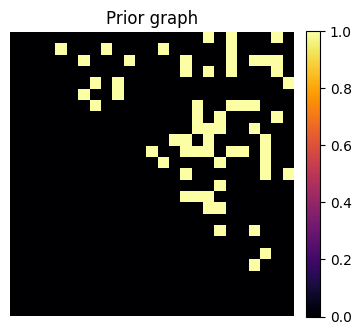

[Epoch 100/1000, patience 14] train: 23.566, val: 23.238
[Epoch 200/1000, patience 24] train: 23.561, val: 23.239
Training terminated after 225 epochs
{'delta_precision_alpha_OC': 0.0, 'delta_coverage_beta_OC': 0.0, 'authenticity_OC': 1.0}
Quality: 0.333
Detection: 0.834
Performance on real: 0.624, on synth: 0.478
Considering ablation setting: COV


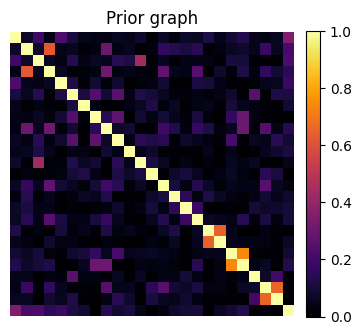

[Epoch 100/1000, patience 14] train: 23.522, val: 23.200
Training terminated after 179 epochs
{'delta_precision_alpha_OC': 0.0, 'delta_coverage_beta_OC': 0.0, 'authenticity_OC': 1.0}
Quality: 0.333
Detection: 0.817
Performance on real: 0.624, on synth: 0.495
Considering ablation setting: BN


Working for n conditional variables: 3: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


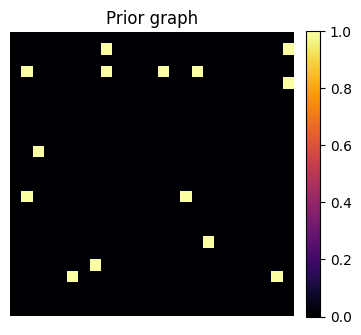

[Epoch 100/1000, patience  0] train: 23.549, val: 23.224
[Epoch 200/1000, patience 24] train: 23.518, val: 23.201
Training terminated after 225 epochs
{'delta_precision_alpha_OC': 0.0, 'delta_coverage_beta_OC': 0.0, 'authenticity_OC': 1.0}
Quality: 0.333
Detection: 0.831
Performance on real: 0.624, on synth: 0.483
Considering ablation setting: DENSE


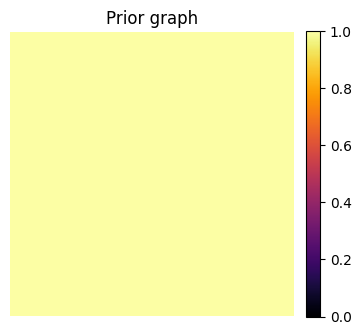

[Epoch 100/1000, patience 20] train: 23.531, val: 23.208


[2023-02-28T16:41:20.673206+0000][130003][ERROR] classifier evaluation failed Only one class present in y_true. ROC AUC score is not defined in that case..
[2023-02-28T16:41:20.687098+0000][130003][ERROR] classifier evaluation failed Only one class present in y_true. ROC AUC score is not defined in that case..
[2023-02-28T16:41:20.721617+0000][130003][ERROR] classifier evaluation failed Only one class present in y_true. ROC AUC score is not defined in that case..
[2023-02-28T16:41:20.736548+0000][130003][ERROR] classifier evaluation failed Only one class present in y_true. ROC AUC score is not defined in that case..
[2023-02-28T16:41:20.775226+0000][130003][ERROR] classifier evaluation failed Only one class present in y_true. ROC AUC score is not defined in that case..
[2023-02-28T16:41:20.789847+0000][130003][ERROR] classifier evaluation failed Only one class present in y_true. ROC AUC score is not defined in that case..
[2023-02-28T16:41:20.801210+0000][130003][ERROR] classifier eval

Training terminated after 129 epochs
{'delta_precision_alpha_OC': 0.0, 'delta_coverage_beta_OC': 0.0, 'authenticity_OC': 1.0}


[2023-02-28T16:41:20.808663+0000][130003][ERROR] classifier evaluation failed This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.
[2023-02-28T16:41:20.810557+0000][130003][ERROR] classifier evaluation failed This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.
[2023-02-28T16:41:20.815220+0000][130003][ERROR] classifier evaluation failed This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.
[2023-02-28T16:41:20.816764+0000][130003][ERROR] classifier evaluation failed This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.
[2023-02-28T16:41:20.972703+0000][130003][ERROR] classifier evaluation failed Expected floating point type for target with class probabilities, got Long.
[2023-02-28T16:41:20.977475+0000][130003][ERROR] classifier evaluation failed Expected floating point type for target with cla

Quality: 0.333
Detection: 0.897
Performance on real: 0.624, on synth: 0.000


In [16]:
from synthcity.plugins.core.dataloader import GenericDataLoader
X_train, X_test = train_test_split(X, random_state=0, test_size=0.2, shuffle=True)

for adj_type in ['ER', 'COV', 'BN', 'DENSE']:
    print(f'Considering ablation setting: {adj_type}')
    adj_mat = get_adj_mat(adj_type, X, n=X_train.shape[1])
    gen = GoggleModel(
        ds_name=dataset,
        input_dim=X_train.shape[1],
        encoder_dim=64,
        encoder_l=2,
        het_encoding=True,
        decoder_dim=64,
        decoder_l=2,
        threshold=0.1,
        het_decoder=False,
        graph_prior=torch.Tensor(adj_mat),
        prior_mask=torch.ones_like(torch.Tensor(adj_mat)),
        device='cuda',
        beta=0.1,
        seed=0
    )
    gen.fit(X_train)
    X_synth = gen.sample(X_test)
    
    X_synth_loader = GenericDataLoader(
        X_synth,
        target_column="target",
    )
    X_test_loader = GenericDataLoader(
        X_test,
        target_column="target",
    )

    res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
    print(f'Quality: {res[0]:.3f}')
    print(f'Detection: {res[2]:.3f}')
    print(f'Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}')